In [1]:
import os
import urllib.request

# 디렉토리 생성
if not os.path.exists("./data/"):
    os.makedirs("./data/")

# 파일 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
                           filename="./data/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
                           filename="./data/ratings_test.txt")

('./data/ratings_test.txt', <http.client.HTTPMessage at 0x19d0f0e2ad0>)

# 데이터 전처리
    1. 비어있는 리뷰 처리
    2. 한글외의 문자는 Nan으로 처리
    3. 같은 리뷰 제거
# 학습 데이터와 테스트 데이터로 정령화
    4. x  와 y로 분리
    5. 단어로 토큰
    6. 패딩
7. 모델 구조 설계
8. 모델 실행

# 1. 비어 있는 리뷰 처리

In [2]:
import os, sys
current_dir = os.path.dirname(os.path.abspath("../module.py"))
sys.path.append(current_dir)
from module import *

In [3]:
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
len(train_data)

150000

In [6]:
len(test_data)

50000

In [7]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64


In [8]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [9]:
print(len(train_data), len(test_data))

149995 49997


# 2. 한글외의 문자는 Nan으로 처리

> 예시

In [10]:
import re
smaple_hangul = '나둘ㅈ대ㅜ래ㅑ@ ;ㅁㅈ;둘'
re.sub(r'[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]', '', smaple_hangul)

'나둘ㅈ대ㅜ래ㅑ ㅁㅈ둘'

In [11]:
train_data['document'] = train_data['document'].apply(lambda x: re.sub(r'[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]', '', x))
test_data['document'] = test_data['document'].apply(lambda y: re.sub(r'[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]', '', y))

In [12]:
train_data['document'].replace('', np.nan, inplace=True)
train_data.dropna(inplace=True)
test_data['document'].replace('', np.nan, inplace=True)
test_data.dropna(inplace=True)

In [13]:
print(len(train_data), len(test_data))

149186 49726


# 3. 같은 리뷰 제거

In [14]:
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

In [15]:
print(len(train_data), len(test_data))

143681 48417


# 4. x 와 y로 분리

In [16]:
X_train = train_data.iloc[:, 1]
y_train = train_data.iloc[:, 2]
X_test = test_data.iloc[:, 1]
y_test = test_data.iloc[:, 2]

# 5. 단어로 토큰

In [17]:
token_x_train = Tokenizer()
token_x_train.fit_on_texts(X_train)
X_train = token_x_train.texts_to_sequences(X_train)
padded_x_train = pad_sequence(X_train, 10)
print(padded_x_train)

[[     0      0      0 ...      4   6591   1061]
 [     0      0      0 ...  67157   6592  40123]
 [     0      0      0 ...      0      0  67158]
 ...
 [     0      0      0 ...  38519 299601  23144]
 [     0      0      0 ...  30701  65744  13213]
 [     0      0      0 ...    131   1958      1]]


In [18]:
token_x_test = Tokenizer()
token_x_test.fit_on_texts(X_test)
X_test = token_x_test.texts_to_sequences(X_test)
padded_x_test = pad_sequence(X_test, 10)

In [19]:
word_size = len(token_x_train.word_index) + 1

In [20]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [21]:
model = Sequential()
model.add(Embedding(word_size, 8, input_length=10))
model.add(tf.keras.layers.Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(padded_x_train, y_train, epochs=20, callbacks=[early_stopping_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 8)             2396832   
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 2,396,913
Trainable params: 2,396,913
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
4491/4491 [==============================] - 94s 21ms/step - loss: 0.5040 - accuracy: 0.7465
Epoch 2/20
4491/4491 [==============================] - 94s 21ms/step - loss: 0.2566 - accuracy: 0.9123
Epoch 3/20
4491/4491 [==============================] - 94s 21ms/step - loss: 0.1239 - accuracy: 0.9636
Epoch 4/20
4491/4491 [==============================] - 97s 22ms/step - loss: 0.0635 - accuracy: 0.9806
Epoch 5/20
4491/4491 [==============================] - 95s 21ms/step - loss: 0.0380 - accuracy: 0.9878
Epoch 6/20
4491/4491 [==============================] - 94s 21ms/step - loss: 0.0251 - accuracy: 0.9918
Epoch 7/20
4491/4491 [==============================] - 94s 21ms/step - loss: 0.0179 - accuracy: 0.9942
Epoch 8/20
4491/4491 [==============================] - 94s 21ms/step - loss: 0.0138 - accuracy: 0.9954
Epoch 9/20
4491/4491 [==============================] - 96s 21ms/step - loss: 0.0111 - accuracy: 0.9965
Epoch 10/20
4491/4491 [==============================] - 96s 21m

In [22]:
print(model.evaluate(padded_x_test, y_test)[1])

1514/1514 [==============================] - 2s 1ms/step - loss: 4.1297 - accuracy: 0.4981
0.4980895221233368


In [25]:
model.save("model.h5")

In [26]:
# y_vloss = history.history['val_loss']
y_loss = history.history['loss']

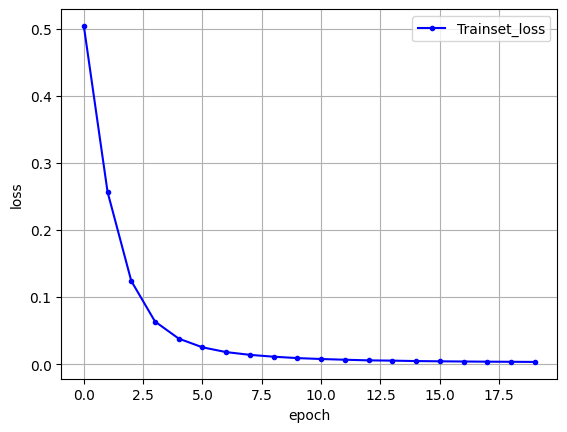

In [27]:
x_len = np.arange(len(y_loss))
# plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()